In [1]:
import matplotlib.pyplot as plt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data
import datetime as dt
import urllib.request, json 
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Pega os precos da ação do MC Donalds - Utiliza a minha API, não rodar muitas vezes pls
api_key = 'xEzLPGkED3ZvDxWbPAa9'
ticker = "MCD" 
url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)
with urllib.request.urlopen(url_string) as url:
    data = json.loads(url.read().decode())
    data = data['Time Series (Daily)']
    df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
    for k,v in data.items():
        date = dt.datetime.strptime(k, '%Y-%m-%d')
        data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                    float(v['4. close']),float(v['1. open'])]
        df.loc[-1,:] = data_row
        df.index = df.index + 1
df = df.sort_values('Date')

In [3]:
# mostra os primeiros valores
df.head()

,Date,Low,High,Close,Open
0,2000-01-03,39.5,40.06,39.63,39.94
1,2000-01-04,38.38,39.56,38.81,39.31
2,2000-01-05,38.81,40.38,39.63,38.81
3,2000-01-06,38.69,39.38,38.88,39.13
4,2000-01-07,38.88,40,39.88,39


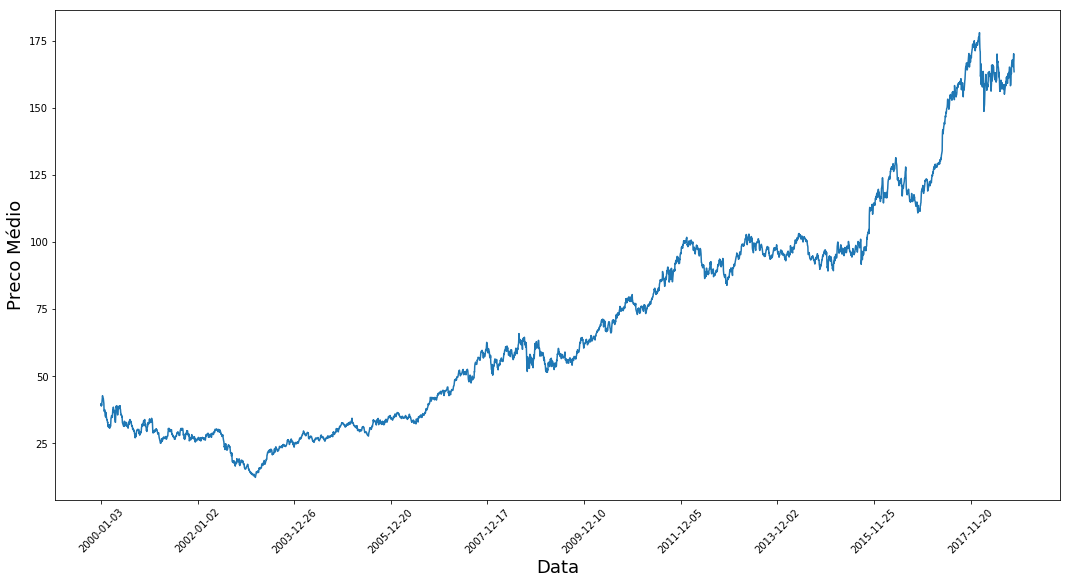

In [4]:
# mostra o grafico
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Data',fontsize=18)
plt.ylabel('Preco Médio',fontsize=18)
plt.show()

In [5]:
# define os tipos das colunas e mostra as informações do dataframe
df = df.astype({'Low':float,'High':float,'Close':float,'Open':float})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4726 entries, 0 to 4725
Data columns (total 5 columns):
Date     4726 non-null object
Low      4726 non-null float64
High     4726 non-null float64
Close    4726 non-null float64
Open     4726 non-null float64
dtypes: float64(4), object(1)
memory usage: 221.5+ KB


In [6]:
# calcula o preco medio e transforma de um dataframe para numpy array
mid_prices = ((df['High']+df['Low'])/2.0).values

In [7]:
# pega o tamanho dos dados e divide em 80/20
tam = len(df)
tam_80 = int(tam*0.8)

In [8]:
# separa os dados de teste e de treino
train_data = mid_prices[:tam_80]
test_data = mid_prices[tam_80:]

In [9]:
# normaliza
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [10]:
# treina utilizando as informações utilizando um tamanho especifico
# https://www.tensorflow.org/tutorials/
di = 0
smoothing_window_size = int(tam_80 / 4)
for di in range(0, int(tam_80*0.6), smoothing_window_size):
    scaler.fit(train_data[di:di + smoothing_window_size])
    train_data[di:di + smoothing_window_size] = scaler.transform(train_data[di:di + smoothing_window_size])

In [11]:
# treina o resto que nao foi normalizado
scaler.fit(train_data[(di+smoothing_window_size):])
train_data[(di+smoothing_window_size):] = scaler.transform(train_data[(di+smoothing_window_size):])

In [12]:
# Reshape dos dados de teste e treino
train_data = train_data.reshape(-1)
test_data = scaler.transform(test_data).reshape(-1)

In [13]:
# deixa a curva mais 'suave'
# https://www.tensorflow.org/tutorials/
EMA = 0.0
gamma = 0.1
for ti in range(tam_80):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

#junta tudo
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [14]:
# calcula o erro do modelo usando o mse
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []
for pred_idx in range(window_size,N):
    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']
    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE: ' + str(round( 0.5*np.mean(mse_errors) ,8)))

MSE: 0.00925317


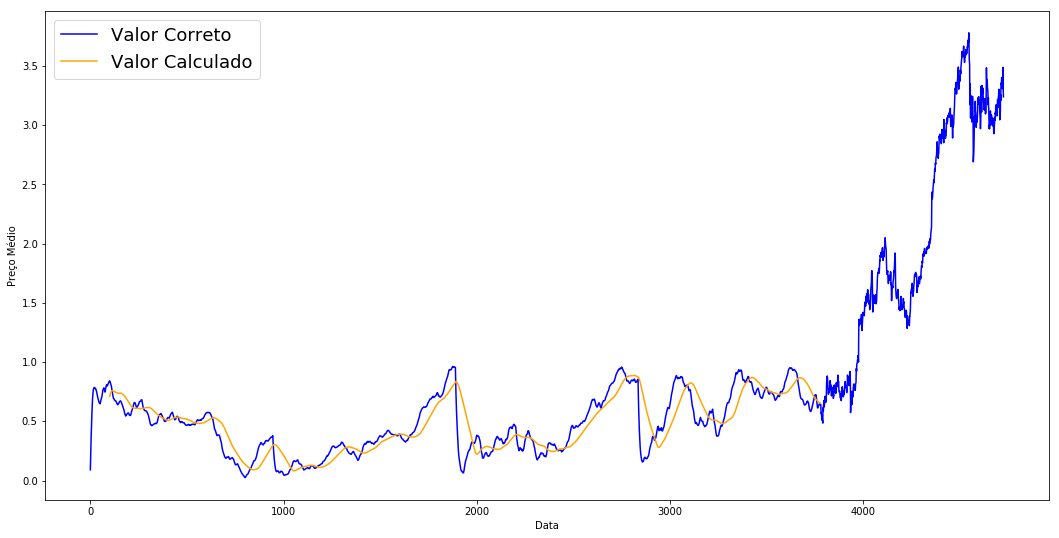

In [15]:
# plota o grafico com os dados de teste
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='Valor Correto')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Valor Calculado')
plt.xlabel('Data')
plt.ylabel('Preço Médio')
plt.legend(fontsize=18)
plt.show()

In [16]:
# calcula o erro do modelo usando o mse
window_size = 100
N = train_data.size
run_avg_predictions = []
run_avg_x = []
mse_errors = []
running_mean = 0.0
run_avg_predictions.append(running_mean)
decay = 0.5
for pred_idx in range(1,N):
    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE: ' + str(round( 0.5*np.mean(mse_errors) ,8)))

MSE: 9.241e-05


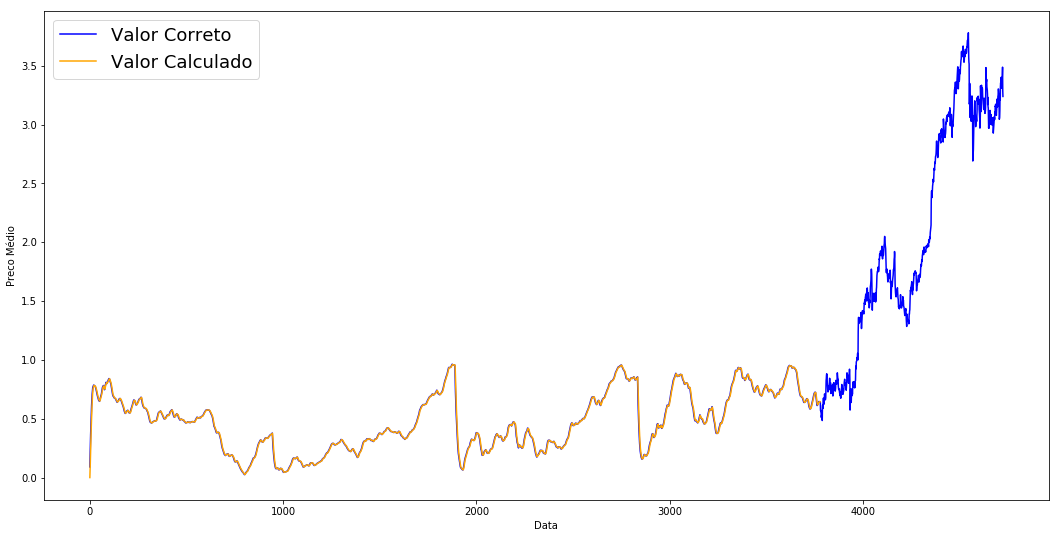

In [17]:
# plota o grafico de treino
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='Valor Correto')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Valor Calculado')
plt.xlabel('Data')
plt.ylabel('Preco Médio')
plt.legend(fontsize=18)
plt.show()